In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import time
from zipfile import ZipFile
import warnings
import pickle
import torch
from torch.utils.data import Dataset
import tsfel
from sklearn.model_selection import StratifiedKFold
from tqdm import tqdm
import lightgbm as lgb
from hiclass import LocalClassifierPerNode, LocalClassifierPerParentNode, LocalClassifierPerLevel
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
warnings.filterwarnings('ignore')

# Data split

In [25]:
def create_folds(train_y, n_splits=5):
    # Create a label array for stratification
    # We'll use the first non-zero label for each row as the stratification target
    stratify_labels = []
    for _, row in train_y.iterrows():
        labels = row[train_y.columns != 'filename'].values
        # Get first non-negative label, or 0 if all negative
        first_positive = next((i for i, x in enumerate(labels) if x >= 0), 0)
        stratify_labels.append(first_positive)
    
    # Create StratifiedKFold object
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    # Generate fold indices
    folds = []
    for train_idx, val_idx in skf.split(train_y, stratify_labels):
        folds.append({
            'train': train_idx,
            'val': val_idx
        })
    
    return folds

In [4]:
train_y = pd.read_csv("../downloads/train_y_v0.1.0.csv")

In [26]:
folds = create_folds(train_y)

# Prepare features

In [58]:
t = torch.load("../logs/prediction.pt")

In [ ]:
torch.concat(t, dim=0).shape

tensor([[2.4911e-01, 4.5417e-04, 7.0436e-05,  ..., 1.9705e-04, 3.6886e-07,
         1.7752e-05],
        [1.2562e-03, 8.2853e-05, 1.1879e-03,  ..., 3.9046e-05, 3.5668e-06,
         7.2983e-04],
        [1.3579e-02, 1.0794e-02, 4.7802e-05,  ..., 2.8615e-03, 7.4951e-08,
         1.0796e-04],
        ...,
        [2.5778e-02, 3.8902e-03, 1.8546e-03,  ..., 1.4022e-03, 3.2061e-04,
         1.6547e-02],
        [2.5778e-02, 3.8902e-03, 1.8546e-03,  ..., 1.4022e-03, 3.2061e-04,
         1.6547e-02],
        [2.5778e-02, 3.8902e-03, 1.8546e-03,  ..., 1.4022e-03, 3.2061e-04,
         1.6547e-02]])

In [6]:
train_X_full = pd.read_csv("../downloads/train_data_features_v3_fixed/train_features_full_v3.csv")
train_X_1 = pd.read_csv("../downloads/train_data_features_v3_fixed/train_features_split1_2_v3.csv")
train_X_2 = pd.read_csv("../downloads/train_data_features_v3_fixed/train_features_split2_2_v3.csv")

In [7]:
print("Train full column num:", len(train_X_full.columns))
print("Train split 1 column num:",len(train_X_1.columns))
print("Train split 2 column num:",len(train_X_2.columns))

Train full column num: 162
Train split 1 column num: 162
Train split 2 column num: 162


In [11]:
test_X = pd.read_csv("../downloads/test_features_full_v3.csv")

In [12]:
feature_list = ['0_Absolute energy',
 '0_Area under the curve',
 '0_Autocorrelation',
 '0_Average power',
 '0_Centroid',
 '0_ECDF Percentile Count_0',
 '0_ECDF Percentile Count_1',
 '0_ECDF Percentile_0',
 '0_ECDF Percentile_1',
 '0_ECDF_0',
 '0_ECDF_1',
 '0_ECDF_2',
 '0_ECDF_3',
 '0_ECDF_4',
 '0_ECDF_5',
 '0_ECDF_6',
 '0_ECDF_7',
 '0_ECDF_8',
 '0_ECDF_9',
 '0_Entropy',
 '0_Histogram mode',
 '0_Interquartile range',
 '0_Kurtosis',
 '0_Max',
 '0_Mean',
 '0_Mean absolute deviation',
 '0_Mean absolute diff',
 '0_Mean diff',
 '0_Median',
 '0_Median absolute deviation',
 '0_Median absolute diff',
 '0_Median diff',
 '0_Min',
 '0_Negative turning points',
 '0_Neighbourhood peaks',
 '0_Peak to peak distance',
 '0_Positive turning points',
 '0_Root mean square',
 '0_Signal distance',
 '0_Skewness',
 '0_Slope',
 '0_Standard deviation',
 '0_Sum absolute diff',
 '0_Variance',
 '0_Zero crossing rate',
 '0_Fundamental frequency',
 '0_Human range energy',
 '0_Max power spectrum',
 '0_Maximum frequency',
 '0_Median frequency',
 '0_Power bandwidth',
 '0_Wavelet entropy',
 'value_median',
 'value_mean',
 'value_qmean',
 'value_max',
 'value_min',
 'value_maxmin',
 'value_diffmax',
 'value_diffmin',
 'value_diffmean',
 'value_diffqmean',
 'value_diffmedian',
 'value_diffmaxmin',
 'time_diffmean',
 'time_diffqmean',
 'time_diffmax',
 'time_diffmin',
 'time_diffmedian',
 'value_std',
 'value_var',
 'value_diffstd',
 'value_diffvar',
 'time_diffstd',
 'time_diffvar',
 'time_burstiness',
 'time_total',
 'time_event_density',
 'time_entropy']

In [13]:
train_X_full = train_X_full[feature_list]
train_X_1 = train_X_1[feature_list]
train_X_2 = train_X_2[feature_list]
test_X = test_X[feature_list]

# Prepare labels

In [14]:
def get_active_labels_np(row):
    """More efficient version using numpy"""
    arr = row.to_numpy() # convert to numpy array
    indices = np.where(arr == 1)[0] # get indices where value is 1
    labels = row.index[indices].tolist() # get labels from indices
    return labels

labelhir = train_y.apply(get_active_labels_np, axis=1).tolist()

In [15]:
# Get a tier dict
ontology_list = list(train_y.columns[1:])

from collections import defaultdict

def build_tree(onto):
    """
    Build a tree so that each term has at most one parent.
    The parent is determined by the longest existing term that is a substring of the child.
    """
    # Sort terms by length so that broader terms are processed (and assigned) first
    sorted_onto = sorted(onto, key=len)
    
    # Dictionaries for storing parent-child relationships
    parent_map = {}             # term -> parent
    children_map = defaultdict(list)  # parent -> [children]

    processed = []
    
    for term in sorted_onto:
        # Find all processed terms that are substrings of 'term'
        potential_parents = [p for p in processed if p in term]
        
        if not potential_parents:
            # No parent found; this term is at the root
            parent_map[term] = None
            children_map[None].append(term)
        else:
            # Pick the longest parent (closest match)
            parent = max(potential_parents, key=len)
            parent_map[term] = parent
            children_map[parent].append(term)
        
        processed.append(term)
    
    return parent_map, children_map

"""
Re-built hierachical labels
"""
level_labels = [[], [], [], [], []]

def print_tree(children_map, root=None, depth=0):
    """
    Recursively print the tree structure with indentation.
    'root=None' means we are listing top-level (root) terms first.
    """
    
    if root is None:
        # For all top-level terms
        for child in sorted(children_map[root]):
            print_tree(children_map, child, depth)
    else:
        # print("  " * depth + root)
        level_labels[depth].append(root)
        for child in sorted(children_map[root]):
            print_tree(children_map, child, depth + 1)

parent_map, children_map = build_tree(ontology_list)
print_tree(children_map)

In [16]:
tiers = {
    1: level_labels[0],
    2: level_labels[1],
    3: level_labels[2],
    4: level_labels[3],
    5: level_labels[4]
}

def get_tier(label):
    for tier_num, tier_list in tiers.items():
        if label in tier_list:
            return tier_num
    return None  # Handle cases where the label isn't found in any tier

def sort_labels(labels):
    return sorted(labels, key=lambda label: (get_tier(label) or float('inf'), label))


In [17]:
sorted_labelhir = [sort_labels(labels) for labels in labelhir]

In [19]:
label_hier = np.array(
    sorted_labelhir,
    dtype=object,
)

In [20]:
padded_label = pd.Series(label_hier).apply(lambda x: x + ['None'] * (5 - len(x)) if len(x) < 5 else x)

In [21]:
# Count Nones at each level
for i in range(5):
    none_count = sum(padded_label.apply(lambda x: x[i] == 'None'))
    print(f"Level {i+1}: {none_count} None values out of {len(padded_label)} total ({none_count/len(padded_label):.2%})")

Level 1: 0 None values out of 31839 total (0.00%)
Level 2: 12321 None values out of 31839 total (38.70%)
Level 3: 20247 None values out of 31839 total (63.59%)
Level 4: 27216 None values out of 31839 total (85.48%)
Level 5: 30936 None values out of 31839 total (97.16%)


# Model Training

In [27]:
from typing import List

def train_random_forest(
    train_X: List[pd.DataFrame],
    _label,
    folds,
    model_class,
    params: dict,
    drop_none=False,
):
    """
    Train random forest models using k-fold cross validation
    
    Args:
        train_X: Training features DataFrame
        _label: Array of labels
        folds: List of dictionaries containing train/val indices
        drop_none: Whether to drop samples with "None" labels
        
    Returns:
        tuple: (list of trained classifiers, list of scores, list of validation predictions)
    """
    classifiers = []
    scores = []
    val_predictions = []  # List to store validation predictions

    for f_idx, fold in enumerate(folds):
        # Prepare train and validation data for this fold
        train_X_fold_list = []
        train_y_fold_list = []
        for trn_x in train_X:
            train_X_fold_list.append(trn_x.iloc[fold['train']])
            train_y_fold_list.append(_label[fold['train']])

        train_X_fold = pd.concat(train_X_fold_list)
        train_y_fold = np.concatenate(train_y_fold_list)

        valid_X_fold_list = []
        valid_y_fold_list = []
        for trn_x in train_X:
            valid_X_fold_list.append(trn_x.iloc[fold['val']])
            valid_y_fold_list.append(_label[fold['val']])

        val_X_fold = pd.concat(valid_X_fold_list)
        val_y_fold = np.concatenate(valid_y_fold_list)
        
        print(f"Train size: {len(train_X_fold)}, Valid size: {len(val_X_fold)}")
        
        if drop_none:
            # Remove samples with "None" labels from training set
            train_mask = train_y_fold != "None"
            train_X_fold = train_X_fold[train_mask]
            train_y_fold = train_y_fold[train_mask]
            
            # Remove samples with "None" labels from validation set
            val_mask = val_y_fold != "None"
            val_X_fold = val_X_fold[val_mask]
            val_y_fold = val_y_fold[val_mask]
            print(f"Dropped train: {len(train_X_fold) - sum(train_mask)}, val: {len(val_X_fold) - sum(val_mask)}")
        
        # Check the train_y_fold. If more than 30% of samples are labeled "None",
        # randomly sample from the "None" to make that ratio no more than 30%.
        none_mask = (train_y_fold == "None")
        none_count = np.sum(none_mask)
        total_samples = len(train_y_fold)
        none_ratio = none_count / total_samples if total_samples > 0 else 0

        if none_ratio > 0.4:
            # Calculate how many "None" labels we should keep (30% of total)
            max_none_to_keep = int(0.4 * (total_samples - none_count))

            # Randomly choose which "None" labels to keep
            none_indices = np.where(none_mask)[0]

            # Fix the random seed before shuffling for reproducibility
            rng = np.random.RandomState(f_idx)
            rng.shuffle(none_indices)
            
            keep_none_indices = none_indices[:max_none_to_keep]

            # Indices of all non-"None" labels
            other_indices = np.where(~none_mask)[0]

            # Combine indices to keep and then sort
            new_indices = np.concatenate([keep_none_indices, other_indices])
            new_indices = np.sort(new_indices)  # Sort so we can index the DataFrame consistently

            # Subset the training data
            train_X_fold = train_X_fold.iloc[new_indices]
            train_y_fold = train_y_fold[new_indices]

            print(f"Sampled: none-ratio: {none_ratio}, removed: {total_samples - max_none_to_keep}")

        # Create and train Random Forest model
        model = model_class(**params)
        model.fit(train_X_fold, train_y_fold)
        
        classifiers.append(model)
        
        # Calculate score and save predictions on validation set
        val_preds = model.predict(val_X_fold)
        score = np.mean(val_preds == val_y_fold)
        scores.append(score)
        val_predictions.append({
            'true_labels': val_y_fold,
            'predicted_labels': val_preds,
            'fold_indices': fold['val']
        })
        print(f"Fold score: {score:.4f}")

    print(f"Average score: {np.mean(scores)}")
    return classifiers, scores, val_predictions

### Train the high precision model by allowing None prediction

In [28]:
prec_classifiers = []
prec_scores = []
prec_val_predictions = []

params = {
    'n_estimators': 100,
    'random_state': 42,
    'n_jobs': 8  # Use all available cores
}

model_cls = RandomForestClassifier

for i in range(5):
    print(f"Training level {i}")
    _classifiers, _scores, _val_predictions = train_random_forest(
        [train_X_full, train_X_1, train_X_2],
        np.array([x[i] for x in padded_label]),
        folds,
        params=params,
        model_class=model_cls
    )
    prec_classifiers.append(_classifiers)
    prec_scores.append(_scores)
    prec_val_predictions.append(_val_predictions)

Training level 0
Train size: 76413, Valid size: 19104
Fold score: 0.8082
Train size: 76413, Valid size: 19104
Fold score: 0.8119
Train size: 76413, Valid size: 19104
Fold score: 0.8091
Train size: 76413, Valid size: 19104
Fold score: 0.8087
Train size: 76416, Valid size: 19101
Fold score: 0.8111
Average score: 0.8097825918241014
Training level 1
Train size: 76413, Valid size: 19104
Fold score: 0.8886
Train size: 76413, Valid size: 19104
Fold score: 0.8859
Train size: 76413, Valid size: 19104
Fold score: 0.8862
Train size: 76413, Valid size: 19104
Fold score: 0.8852
Train size: 76416, Valid size: 19101
Fold score: 0.8885
Average score: 0.8868892950433546
Training level 2
Train size: 76413, Valid size: 19104
Sampled: none-ratio: 0.6355463075654666, removed: 65274
Fold score: 0.8585
Train size: 76413, Valid size: 19104
Sampled: none-ratio: 0.6352322248832005, removed: 65264
Fold score: 0.8517
Train size: 76413, Valid size: 19104
Sampled: none-ratio: 0.635742609241883, removed: 65280
Fold 

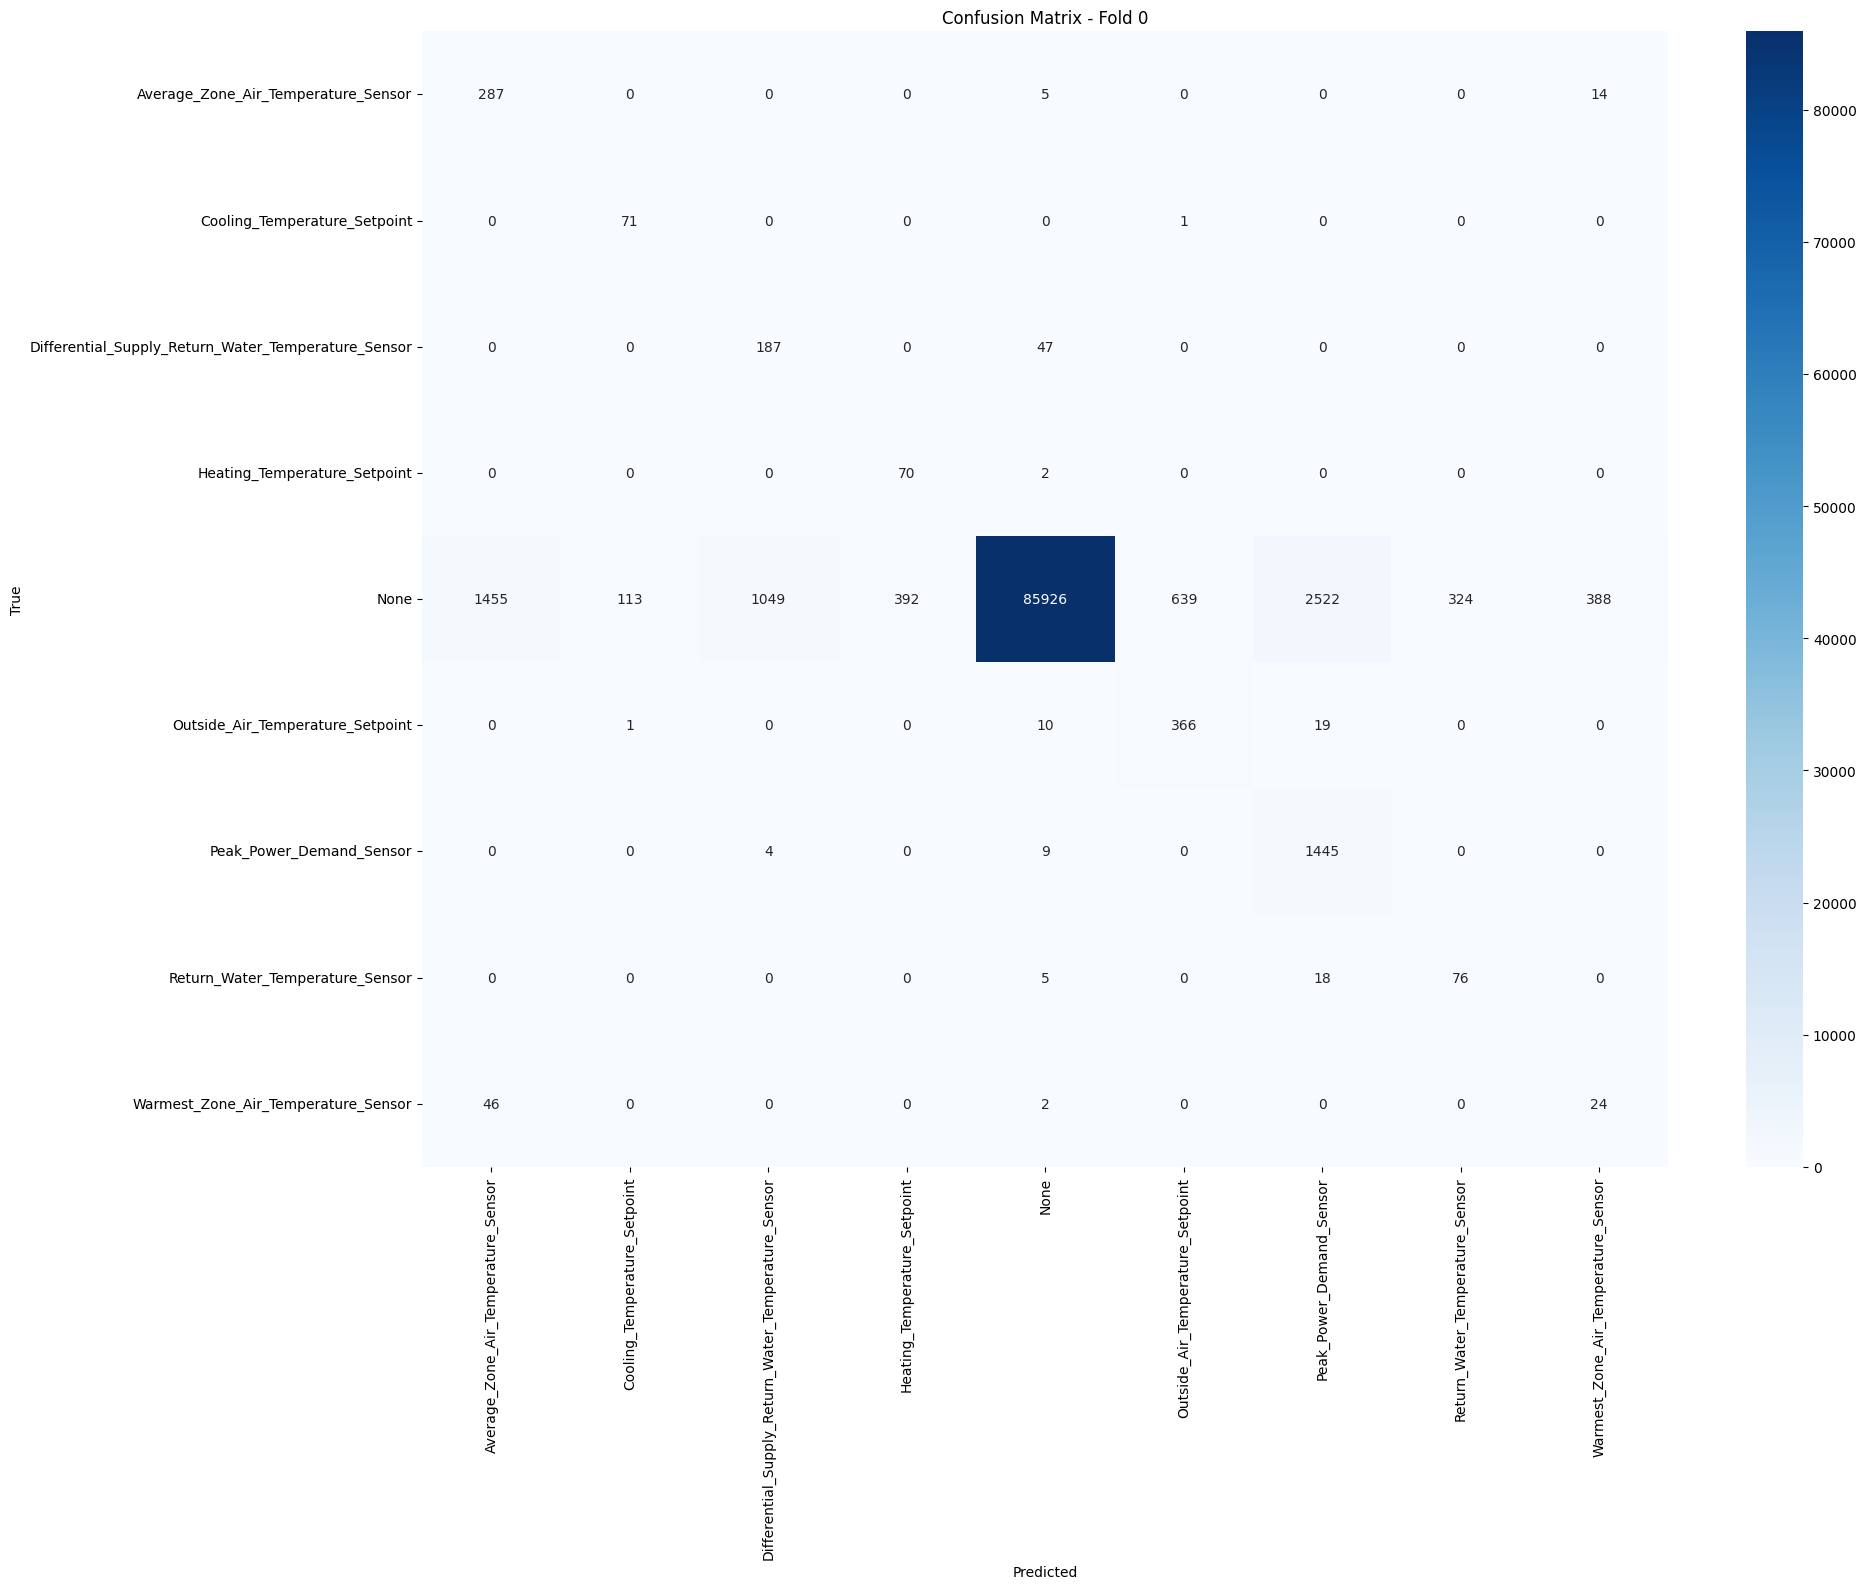


Classification Report:
                                                     precision    recall  f1-score   support

                Average_Zone_Air_Temperature_Sensor       0.16      0.94      0.27       306
                       Cooling_Temperature_Setpoint       0.38      0.99      0.55        72
Differential_Supply_Return_Water_Temperature_Sensor       0.15      0.80      0.25       234
                       Heating_Temperature_Setpoint       0.15      0.97      0.26        72
                                               None       1.00      0.93      0.96     92808
                   Outside_Air_Temperature_Setpoint       0.36      0.92      0.52       396
                           Peak_Power_Demand_Sensor       0.36      0.99      0.53      1458
                    Return_Water_Temperature_Sensor       0.19      0.77      0.30        99
                Warmest_Zone_Air_Temperature_Sensor       0.06      0.33      0.10        72

                                           a

In [29]:
# Create confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Stack all 5 folds' predictions and true labels together
all_true_labels = np.concatenate([_fold['true_labels'] for _fold in prec_val_predictions[4]])
all_predicted_labels = np.concatenate([_fold['predicted_labels'] for _fold in prec_val_predictions[4]])

# Compute confusion matrix
cm = confusion_matrix(all_true_labels, all_predicted_labels)

# Create a figure with larger size
plt.figure(figsize=(20, 16))

# Create heatmap
sns.heatmap(cm, 
            xticklabels=np.unique(all_true_labels),
            yticklabels=np.unique(all_true_labels),
            annot=True, 
            fmt='d',
            cmap='Blues')

plt.title('Confusion Matrix - Fold 0')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Print classification report for more detailed metrics
from sklearn.metrics import classification_report
print("\nClassification Report:")
print(classification_report(all_true_labels, all_predicted_labels))

In [30]:
cliped_text_X = np.clip(test_X, a_min=None, a_max=np.finfo(np.float32).max)

In [31]:
def make_predictions_with_models(classifiers, test_data):
    """
    Make probability predictions using multiple classifier models
    
    Args:
        classifiers: List of trained classifier models
        test_data: Test data to make predictions on
        
    Returns:
        List of probability predictions from each classifier
    """
    test_preds_all = []
    for clf in tqdm(classifiers):
        pred = clf.predict_proba(test_data)
        test_preds_all.append(pred)
    return test_preds_all

In [32]:
def align_and_combine_predictions(classifiers, test_preds_all, test_data, threshold=0.0):
    """
    Aligns predictions from multiple classifiers and combines them through averaging
    
    Args:
        classifiers: List of trained classifier models
        test_preds_all: List of probability predictions from each classifier
        test_data: Test data used for predictions
        threshold: Minimum probability threshold for making predictions
        
    Returns:
        Final class predictions after aligning and combining probabilities
    """
    # Get the common classes across all classifiers
    all_classes = classifiers[0].classes_
    test_preds_aligned = []

    # Make predictions with each fold's model and align them 
    for i, clf in tqdm(enumerate(classifiers)):
        pred = test_preds_all[i]
        # Create a mapping to align predictions with common classes
        pred_dict = {_cls: idx for idx, _cls in enumerate(clf.classes_)}
        aligned_pred = np.zeros((len(test_data), len(all_classes)))
        
        for i, _cls in enumerate(all_classes):
            if _cls in pred_dict:
                aligned_pred[:, i] = pred[:, pred_dict[_cls]]
        
        test_preds_aligned.append(aligned_pred)

    # Stack and average the aligned predictions
    test_preds_all = np.stack(test_preds_aligned)
    test_preds_proba = test_preds_all.mean(axis=0)

    # Get max probabilities for each prediction
    max_probs = np.max(test_preds_proba, axis=1)
    
    # Convert probabilities to class predictions, using threshold
    test_preds = np.array(['None'] * len(test_data), dtype=object)
    confident_mask = max_probs >= threshold
    test_preds[confident_mask] = all_classes[np.argmax(test_preds_proba[confident_mask], axis=1)]
    
    return test_preds

In [50]:
test_preds_list = []
for i in range(5):
    print(f"Predicting level {i}")
    test_preds_all = make_predictions_with_models(prec_classifiers[i], cliped_text_X)
    test_preds_list.append(align_and_combine_predictions(prec_classifiers[i], test_preds_all, cliped_text_X))

Predicting level 0


100%|██████████| 5/5 [00:11<00:00,  2.23s/it]
5it [00:00, 42.75it/s]


Predicting level 1


100%|██████████| 5/5 [00:19<00:00,  3.81s/it]
5it [00:02,  2.48it/s]


Predicting level 2


100%|██████████| 5/5 [00:17<00:00,  3.41s/it]
5it [00:01,  4.25it/s]


Predicting level 3


100%|██████████| 5/5 [00:12<00:00,  2.54s/it]
5it [00:00,  5.59it/s]


Predicting level 4


100%|██████████| 5/5 [00:05<00:00,  1.09s/it]
5it [00:00, 27.87it/s]


In [ ]:
# Convert to array and process None values
stacked = np.stack(test_preds_list).transpose()
for row in tqdm(stacked):
    # Find first occurrence of 'None' if any
    none_idx = np.where(row == 'None')[0]
    if len(none_idx) > 0:
        # Set all elements after first None to None
        first_none = none_idx[0]
        row[first_none:] = 'None'
        
stacked

array([['Sensor', 'Pressure_Sensor', 'None', 'None', 'None'],
       ['Sensor', 'Flow_Sensor', 'Chilled_Water_Supply_Flow_Sensor',
        'Water_Flow_Sensor', 'None'],
       ['Setpoint', 'Temperature_Setpoint', 'None',
        'Electrical_Power_Sensor', 'Peak_Power_Demand_Sensor'],
       ...,
       ['Sensor', 'None', 'None', 'None', 'None'],
       ['Sensor', 'None', 'None', 'None', 'None'],
       ['Alarm', 'None', 'None', 'None', 'None']], dtype=object)

In [52]:
columnlist = ['Active_Power_Sensor', 'Air_Flow_Sensor',
       'Air_Flow_Setpoint', 'Air_Temperature_Sensor',
       'Air_Temperature_Setpoint', 'Alarm', 'Angle_Sensor',
       'Average_Zone_Air_Temperature_Sensor',
       'Chilled_Water_Differential_Temperature_Sensor',
       'Chilled_Water_Return_Temperature_Sensor',
       'Chilled_Water_Supply_Flow_Sensor',
       'Chilled_Water_Supply_Temperature_Sensor', 'Command',
       'Cooling_Demand_Sensor', 'Cooling_Demand_Setpoint',
       'Cooling_Supply_Air_Temperature_Deadband_Setpoint',
       'Cooling_Temperature_Setpoint', 'Current_Sensor',
       'Damper_Position_Sensor', 'Damper_Position_Setpoint', 'Demand_Sensor',
       'Dew_Point_Setpoint', 'Differential_Pressure_Sensor',
       'Differential_Pressure_Setpoint',
       'Differential_Supply_Return_Water_Temperature_Sensor',
       'Discharge_Air_Dewpoint_Sensor', 'Discharge_Air_Temperature_Sensor',
       'Discharge_Air_Temperature_Setpoint',
       'Discharge_Water_Temperature_Sensor', 'Duration_Sensor',
       'Electrical_Power_Sensor', 'Energy_Usage_Sensor',
       'Filter_Differential_Pressure_Sensor', 'Flow_Sensor', 'Flow_Setpoint',
       'Frequency_Sensor', 'Heating_Demand_Sensor', 'Heating_Demand_Setpoint',
       'Heating_Supply_Air_Temperature_Deadband_Setpoint',
       'Heating_Temperature_Setpoint', 'Hot_Water_Flow_Sensor',
       'Hot_Water_Return_Temperature_Sensor',
       'Hot_Water_Supply_Temperature_Sensor', 'Humidity_Setpoint',
       'Load_Current_Sensor', 'Low_Outside_Air_Temperature_Enable_Setpoint',
       'Max_Air_Temperature_Setpoint', 'Min_Air_Temperature_Setpoint',
       'Outside_Air_CO2_Sensor', 'Outside_Air_Enthalpy_Sensor',
       'Outside_Air_Humidity_Sensor',
       'Outside_Air_Lockout_Temperature_Setpoint',
       'Outside_Air_Temperature_Sensor', 'Outside_Air_Temperature_Setpoint',
       'Parameter', 'Peak_Power_Demand_Sensor', 'Position_Sensor',
       'Power_Sensor', 'Pressure_Sensor', 'Rain_Sensor',
       'Reactive_Power_Sensor', 'Reset_Setpoint',
       'Return_Air_Temperature_Sensor', 'Return_Water_Temperature_Sensor',
       'Room_Air_Temperature_Setpoint', 'Sensor', 'Setpoint',
       'Solar_Radiance_Sensor', 'Speed_Setpoint', 'Static_Pressure_Sensor',
       'Static_Pressure_Setpoint', 'Status', 'Supply_Air_Humidity_Sensor',
       'Supply_Air_Static_Pressure_Sensor',
       'Supply_Air_Static_Pressure_Setpoint', 'Supply_Air_Temperature_Sensor',
       'Supply_Air_Temperature_Setpoint', 'Temperature_Sensor',
       'Temperature_Setpoint', 'Thermal_Power_Sensor', 'Time_Setpoint',
       'Usage_Sensor', 'Valve_Position_Sensor', 'Voltage_Sensor',
       'Warmest_Zone_Air_Temperature_Sensor', 'Water_Flow_Sensor',
       'Water_Temperature_Sensor', 'Water_Temperature_Setpoint',
       'Wind_Direction_Sensor', 'Wind_Speed_Sensor',
       'Zone_Air_Dewpoint_Sensor', 'Zone_Air_Humidity_Sensor',
       'Zone_Air_Humidity_Setpoint', 'Zone_Air_Temperature_Sensor'
]

In [53]:
zipftest = ZipFile('../downloads/test_X_v0.1.0.zip', 'r')

In [54]:
listtestfile = zipftest.namelist()[1:]

In [55]:
stackedfinalresult = pd.DataFrame(columns=['filename'])
stackedfinalresult['filename'] = pd.Series(listtestfile).apply(lambda x: x.split("/")[-1])

for labelname in columnlist:
    stackedfinalresult[labelname] = 0

test_preds = stacked
for i in tqdm(range(len(test_preds))):
    # stackedfinalresult.loc[i, test_preds[i]] = 1
    predlist = test_preds[i].tolist()
    predlist = [x for x in predlist if x != 'None']
    for predlabelname in predlist:
    	stackedfinalresult.loc[i, predlabelname] = 1

100%|██████████| 315720/315720 [01:10<00:00, 4451.04it/s]


In [56]:
stackedfinalresult = stackedfinalresult.assign(**{col: stackedfinalresult[col].astype(float) for col in stackedfinalresult.columns if col != "filename"})

In [57]:
stackedfinalresult.to_csv("../logs/submit/hier_rf_slide_aug_2.csv", index=False)

In [46]:
stackedfinalresult

,filename,Active_Power_Sensor,Air_Flow_Sensor,Air_Flow_Setpoint,Air_Temperature_Sensor,Air_Temperature_Setpoint,Alarm,Angle_Sensor,Average_Zone_Air_Temperature_Sensor,Chilled_Water_Differential_Temperature_Sensor,...,Water_Flow_Sensor,Water_Temperature_Sensor,Water_Temperature_Setpoint,Wind_Direction_Sensor,Wind_Speed_Sensor,Zone_Air_Dewpoint_Sensor,Zone_Air_Humidity_Sensor,Zone_Air_Humidity_Setpoint,Zone_Air_Temperature_Sensor,None
0,test_X20367.pkl,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,test_X103084.pkl,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,test_X6910.pkl,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,test_X66332.pkl,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,test_X38528.pkl,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315715,test_X325790.pkl,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
315716,test_X61444.pkl,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
315717,test_X221284.pkl,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
315718,test_X115827.pkl,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
